In [2]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} 
    h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render 
    h1 { font-size: 30px; } h1 {padding: 10px 12px;font-style: bold; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render 
    h3 { padding: 10px 12px; background-color: #16bedb; position: static; color: #ffffff; font-size: 20px;} 
    h4 {padding: 8px 20px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #57fa05; color: #ffffff; font-size: 18px;  border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
    <script> code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle);</script>
    <form action="javascript:code_toggle()"><input type="submit" value="Hide/show all code."></form>
''')

# Sydney Liveability Analysis

## Group - 5  F10Adv-01 : Pratul Singh Raghava & Amanda Walpitage

This Jupyter Notebook contains the code and processes followed to calculate a **Liveability score** for each SA2 Area in Greater Sydney and further analysis of Inner Sydney suburbs through the integration of additional datasets. The results of this analysis have further been compared to parameters like Median Rent and Median Income of each neighbourhood in an attempt to figure out their correlation with the analysis results. This notebook also contains the analysis by an Unsupervised Machine Learning Algorithm and the comparison of its results with the tradional methods used before.

### Importing Modules

Before we proceed with the analysis, we must first import all the necessary modules required to perform the analysis.

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import json
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.manifold import TSNE

# TASK - 1

### Importing Datasets

#### Importing Spatial Data

We import the spatial data from .shp files and store them in GeoPandas DataFrames, which are just like Pandas DataFrames, but with support for Geo-Spatial data.

In [4]:
# Importing the ABS SA2 Shape Data
sa2_data = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")

# Importing the shape data of theft ’hotspots’ in NSW 
break_and_enter = gpd.read_file("break_and_enter/BreakEnterDwelling_JanToDec2021.shp")

# Importing the shape data for future Government schools catchments
school_catchments_future = gpd.read_file("school_catchments/catchments_future.shp")

# Importing the shape data for primary Government schools catchments
school_catchments_primary = gpd.read_file("school_catchments/catchments_primary.shp")

# Importing the shape data for secondary Government schools catchments
school_catchments_secondary = gpd.read_file("school_catchments/catchments_secondary.shp")

#### Importing Non-Spatial CSV Data

We import the non-spatial data from .csv files and store them in Pandas DataFrames.

In [5]:
# Importing the Census data on neighbourhoods(SA2-level areas)
neighbourhoods = pd.read_csv('Neighbourhoods.csv')

# Importing the Business statistics per SA2-area
BusinessStats = pd.read_csv('BusinessStats.csv')

#### Importing Spatial GeoJSON Data

Now, we import the spatial data from the additional datasets
[Playgrounds](https://data.cityofsydney.nsw.gov.au/datasets/cityofsydney::playgrounds/about)
&
[Lights](https://data.cityofsydney.nsw.gov.au/datasets/cityofsydney::lights/about)
downloaded from the [
City of Sydney Data hub](https://data.cityofsydney.nsw.gov.au/).

In [6]:
Playgrounds_json = json.load(open('Playgrounds.geojson'))

Playgrounds_DataFrame = pd.DataFrame(Playgrounds_json["features"])
Playgrounds_pandas_data=[]
for index, row in Playgrounds_DataFrame.iterrows():
    append_row = [row["geometry"]["coordinates"][0],row["geometry"]["coordinates"][1],row["properties"]["Name"]]
    Playgrounds_pandas_data.append(append_row)
    
Playgrounds = pd.DataFrame(Playgrounds_pandas_data, columns = ['X', 'Y','Name'])
Playgrounds['geom'] = gpd.points_from_xy(Playgrounds.X, Playgrounds.Y)  # creating the geometry column
Playgrounds = Playgrounds.drop(columns=['X', 'Y'])  # removing the old latitude/longitude fields

In [7]:
Lights_json = json.load(open('Lights.geojson'))
Lights_DataFrame = pd.DataFrame(Lights_json["features"])
Lights_pandas_data=[]
for index, row in Lights_DataFrame.iterrows():
    append_row = [row["geometry"]["coordinates"][0],row["geometry"]["coordinates"][1],row["properties"]["Location"]]
    Lights_pandas_data.append(append_row)
    
Lights = pd.DataFrame(Lights_pandas_data, columns = ['X', 'Y','Location'])
Lights['geom'] = gpd.points_from_xy(Lights.X, Lights.Y)  # creating the geometry column
Lights = Lights.drop(columns=['X', 'Y'])  # removing the old latitude/longitude fields

### Cleaning the Datasets

We clean the **sa2_data** dataset by dropping those rows where either the locations are :

a) `No usual address` - people with no fixed place of abode, or 

b) `Migratory - Offshore - Shipping` - people who are in transit (Migratory) or on oil rigs and drilling platforms (Offshore) or on board vessels (Shipping).

In [8]:
sa2_data = sa2_data.drop(sa2_data[(sa2_data['SA4_NAME16'].str.contains("No usual address", case=False)) |
                                  (sa2_data['SA4_NAME16'].str.contains("Migratory - Offshore - Shipping", case=False)) |
                         sa2_data['SA3_NAME16'].str.contains("No usual address", case=False) |
                         sa2_data['SA3_NAME16'].str.contains("Migratory - Offshore - Shipping", case=False) |
                         sa2_data['SA2_NAME16'].str.contains("No usual address", case=False) | 
                         sa2_data['SA2_NAME16'].str.contains("Migratory - Offshore - Shipping", case=False) | 
                         sa2_data['GCC_NAME16'].str.contains("No usual address", case=False) | 
                         sa2_data['GCC_NAME16'].str.contains("Migratory - Offshore - Shipping", case=False) |
                         sa2_data['GCC_NAME16'].str.contains("Rest of", case=False)].index
                        )

For our Task-2 analysis, we filter our data to only contain rows with their region as **'Greater Sydney'**.

In [ ]:
sa2_data = sa2_data[sa2_data['GCC_NAME16']=='Greater Sydney'] 

Now, we clean the **neighbourhoods** dataset and get rid of the rows where the young population value is zero or null, to avoid ZeroDivisionError and other potential errors later on.

In [9]:
neighbourhoods = neighbourhoods.drop(neighbourhoods[(neighbourhoods['population'].isnull()) | 
                                      (neighbourhoods['0-4'].isnull()) | 
                                      (neighbourhoods['5-9'].isnull()) | 
                                      (neighbourhoods['10-14'].isnull() )| 
                                      (neighbourhoods['15-19'].isnull())].index)
neighbourhoods = neighbourhoods.drop(neighbourhoods[(neighbourhoods['0-4']+neighbourhoods['5-9']+neighbourhoods['10-14']+neighbourhoods['15-19'])<=0].index)

# neighbourhoods = neighbourhoods.drop(neighbourhoods[neighbourhoods['population']<=0].index)

We find that the `population` column in the **neighbourhoods** dataset contains values stored as String datatypes. Since we require the population values to be of integer datatypes for our analysis, we iterate through these values and explicitly convert them from Strings to Integers.

In [10]:
for index, row in neighbourhoods.iterrows():
    old_value = row['population']
    old_value_split = str(row['population']).split(",")
    new_value = ""
    for i in old_value_split :
        new_value = new_value+i
    neighbourhoods['population'] = neighbourhoods['population'].replace([old_value],int(new_value))

### Connecting to PostgreSQL

 Now, we create a helper function to establish a connection to the servers.

In [11]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

Running this successfully connects to the PostgreSQL database.

In [12]:
db, conn = pgconnect(credentials)

Connected successfully.


### SRID Transformations

Ensuring the spatial data types from GeoPandas are the same as those expected by PostGIS requires conversion to the **Well-Known Text (WKT)** format, as an intermediate step. This can be done using the `geoalchemy2` library, to convert from the `shapely` types in GeoPandas to the WKT format in PostGIS.

We'll also be sure to specify the **Spatial Reference Identifier (SRID)** - in this case 4326, to represent the [WGS84 world geodetic coordinate system](https://en.wikipedia.org/wiki/World_Geodetic_System) used by our datasets. The following code simply converts the 'geom' column of the **Lights** & **Playgrounds** dataframe accordingly.

In [14]:
srid = 4326
Playgrounds['geom'] = Playgrounds['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
Lights['geom'] = Lights['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

Converting the polygons in our **sa2_data**, **break_and_enter**, **school_catchments_primary** , **school_catchments_secondary** & **school_catchments_future** dataframes requires more work. We'll first ensure they're all represented as multipolygons (of which polygons are a subset), and then conduct the same WKT conversion, all using a simple helper function.Then we converts the 'geom' column of the  dataframe accordingly.

In [15]:
def create_wkt_element(geom, srid):
    if geom!=None :
        if geom.geom_type == 'Polygon':
            geom = MultiPolygon([geom])
        return WKTElement(geom.wkt, srid)

sa2_data_og = sa2_data.copy()  # creating a copy of the original for later
sa2_data['geom'] = sa2_data['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
sa2_data = sa2_data.drop(columns="geometry")  # deleting the old copy

break_and_enter['geom'] = break_and_enter['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
break_and_enter = break_and_enter.drop(columns="geometry")  # deleting the old copy

school_catchments_future['geom'] = school_catchments_future['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
school_catchments_future = school_catchments_future.drop(columns="geometry")  # deleting the old copy

school_catchments_primary['geom'] = school_catchments_primary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
school_catchments_primary = school_catchments_primary.drop(columns="geometry")  # deleting the old copy

school_catchments_secondary['geom'] = school_catchments_secondary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
school_catchments_secondary = school_catchments_secondary.drop(columns="geometry")  # deleting the old copy

In [16]:
sa2_data = sa2_data[['SA2_MAIN16', 'SA2_NAME16','SA3_NAME16','AREASQKM16','geom']].copy()
break_and_enter = break_and_enter[['OBJECTID', 'Density','ORIG_FID','Shape_Area','geom']].copy()
school_catchments_future = school_catchments_future[['USE_ID','CATCH_TYPE', 'USE_DESC','geom']].copy()
school_catchments_primary = school_catchments_primary[['USE_ID', 'USE_DESC','geom']].copy()
school_catchments_secondary = school_catchments_secondary[['USE_ID', 'USE_DESC','geom']].copy()
neighbourhoods = neighbourhoods[['area_id','land_area','population', 'number_of_dwellings','number_of_businesses','median_annual_household_income','avg_monthly_rent','0-4','5-9','10-14','15-19']].copy()
BusinessStats = BusinessStats[['area_id','number_of_businesses','accommodation_and_food_services','retail_trade','agriculture_forestry_and_fishing','health_care_and_social_assistance','public_administration_and_safety','transport_postal_and_warehousing']].copy()
Lights = Lights[['Location', 'geom']].copy()
Playgrounds = Playgrounds[['Name', 'geom']].copy()

### Creating SQL Tables

We create new tables in our schema so we can insert data into them to conduct our analysis.

In [17]:
# SQL Table for sa2_data
conn.execute("""
DROP TABLE IF EXISTS sa2_data;
CREATE TABLE sa2_data (
    "SA2_MAIN16" INTEGER,
    "SA2_NAME16" VARCHAR(80),
    "SA3_NAME16" VARCHAR(80),
    "AREASQKM16" NUMERIC,
    "geom" GEOMETRY(MULTIPOLYGON,4326)
);"""
)

# SQL Table for neighbourhood Data
conn.execute("""
DROP TABLE IF EXISTS neighbourhood;
CREATE TABLE neighbourhood (
    "area_id" INTEGER,
    "land_area" NUMERIC,
    "population" INTEGER,
    "number_of_dwellings" VARCHAR(80),
    "number_of_businesses" INTEGER,
    "median_annual_household_income" NUMERIC,
    "avg_monthly_rent" INTEGER,
    "0-4" INTEGER,
    "5-9" INTEGER,
    "10-14" INTEGER,
    "15-19" INTEGER
);"""
)

# SQL Table for break and enter Data
conn.execute("""
DROP TABLE IF EXISTS break_and_enter;
CREATE TABLE break_and_enter (
    "OBJECTID" INTEGER,
    "Density" VARCHAR(80),
    "ORIG_FID" INTEGER,
    "Shape_Area" NUMERIC,
    "geom" GEOMETRY(MULTIPOLYGON,4326)
);"""
)

# SQL Table for school_catchments_future Data
conn.execute("""
DROP TABLE IF EXISTS school_catchments_future;
CREATE TABLE school_catchments_future (
    "USE_ID" INTEGER, 
    "CATCH_TYPE" VARCHAR(80), 
    "USE_DESC" VARCHAR(80),
    "geom" GEOMETRY(MULTIPOLYGON,4326)
    
);"""
)

# SQL Table for school_catchments_primary Data
conn.execute("""
DROP TABLE IF EXISTS school_catchments_primary;
CREATE TABLE school_catchments_primary (
    "USE_ID" INTEGER,
    "USE_DESC" VARCHAR(80),
    "geom" GEOMETRY(MULTIPOLYGON,4326)
    
);"""
)

# SQL Table for school_catchments_secondary Data
conn.execute("""
DROP TABLE IF EXISTS school_catchments_secondary;
CREATE TABLE school_catchments_secondary (
    "USE_ID" INTEGER,
    "USE_DESC" VARCHAR(80),
    "geom" GEOMETRY(MULTIPOLYGON,4326)
    
);"""
)


# SQL Table for BusinessStats Data
conn.execute("""
DROP TABLE IF EXISTS businessstats;
CREATE TABLE businessstats (
    "area_id" INTEGER,
    "number_of_businesses" INTEGER,
    "accommodation_and_food_services" INTEGER,
    "retail_trade" INTEGER,
    "agriculture_forestry_and_fishing" INTEGER,
    "health_care_and_social_assistance" INTEGER,
    "public_administration_and_safety" INTEGER,
    "transport_postal_and_warehousing" INTEGER
);"""
)

# SQL Table for Playgrounds Data
conn.execute("""
DROP TABLE IF EXISTS playgrounds;
CREATE TABLE playgrounds (
   "Name" VARCHAR(200),
   geom GEOMETRY(POINT, 4326)
);"""
)

# SQL Table for Lights Data
conn.execute("""
DROP TABLE IF EXISTS lights;
CREATE TABLE lights (
   "Location" VARCHAR(200),
   geom GEOMETRY(POINT, 4326)
);"""
)

We can run the below code to confirm that our SQL tables have been successfully created in the public schema of our PostgreSQL server.

In [44]:
from sqlalchemy import inspect
for table in inspect(db).get_table_names(schema='public') :
    print(table)

spatial_ref_sys
public.BusinessStats
BusinessStats
Lights
Playgrounds
cities
world
task3_results
task3_data
lights_database
playgrounds_database
sa2_data
neighbourhood
break_and_enter
school_catchments_future
school_catchments_primary
school_catchments_secondary
businessstats
playgrounds
lights
school_catchments_combined
results


### Data Ingestion

Now, we load the data from the pandas DataFrames into their respective SQL tables. We specifically define the new datatype of our `geom` columns that is `Multipolygon`.

In [18]:
# Inserting the school datasets into SQL tables
school_catchments_future.to_sql("school_catchments_future", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
school_catchments_primary.to_sql("school_catchments_primary", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
school_catchments_secondary.to_sql("school_catchments_secondary", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

# Inserting the additional datasets into SQL tables
Lights.to_sql('lights', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
Playgrounds.to_sql('playgrounds', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})

# Inserting the other datasets into SQL tables
sa2_data.to_sql('sa2_data', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
neighbourhoods.to_sql('neighbourhood', conn, if_exists='append', index=False)
BusinessStats.to_sql('businessstats', conn, if_exists='append', index=False)
break_and_enter.to_sql("break_and_enter", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

### Reorganising SQL Tables

We combine the 3 different school catchment tables into a new table for the purpose of practicality. We can now get rid of the earlier tables since they are not of any further use.

In [27]:
sql="""
DROP TABLE IF EXISTS school_catchments_combined;
CREATE TABLE school_catchments_combined (
    "USE_ID" INTEGER,
    "USE_DESC" VARCHAR(80),
    "geom" GEOMETRY(MULTIPOLYGON,4326)
);

INSERT INTO school_catchments_combined("USE_ID","USE_DESC","geom")
    SELECT * FROM school_catchments_primary
    UNION ALL
    SELECT * FROM school_catchments_secondary
    UNION ALL
    SELECT "USE_ID","USE_DESC","geom" FROM school_catchments_future
    ;

DROP TABLE IF EXISTS school_catchments_primary;
DROP TABLE IF EXISTS school_catchments_secondary;
DROP TABLE IF EXISTS school_catchments_future;
"""

query(conn,sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


# TASK - 2

## Main Analysis for Task-2

Error encountered: 
This result object does not return rows. It has been closed automatically.


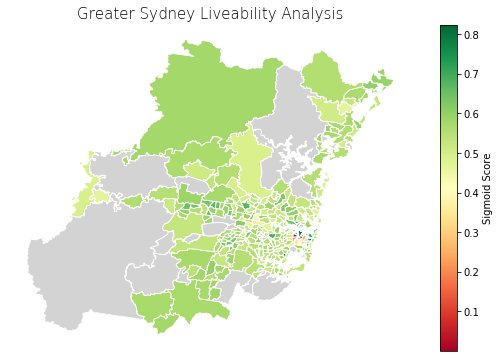

In [28]:
sql="""
DROP TABLE IF EXISTS results;
CREATE TABLE results
AS

with Health AS 
(SELECT avg(1000.0*bs."health_care_and_social_assistance"/n."population") AS mean,
stddev(1000.0*bs."health_care_and_social_assistance"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Retail AS
(SELECT avg(1000.0*bs."retail_trade"/n."population") AS mean,
stddev(1000.0*bs."retail_trade"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Accom AS
(SELECT avg(1000.0*bs."accommodation_and_food_services"/n."population") AS mean,
stddev(1000.0*bs."accommodation_and_food_services"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Crime AS 
(SELECT AVG(q1) AS mean,
stddev(q1) AS sd
FROM ( SELECT AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")as q1
        FROM break_and_enter be join sa2_data s ON
        ST_Intersects(s.geom,be.geom)
        GROUP BY s."SA2_NAME16") a ),
        
Schools AS 
(SELECT AVG(Schools) AS mean,
stddev(Schools) as sd 
FROM (SELECT 1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19")) AS Schools
    FROM school_catchments_combined sc, sa2_data s, neighbourhood n
    WHERE ST_Intersects(s.geom,sc.geom)
    AND s."SA2_MAIN16" = n."area_id"
    GROUP BY s."SA2_NAME16" ) b)

SELECT s."SA2_NAME16",

abs((1000.0*AVG(bs."health_care_and_social_assistance")/AVG(n."population"))-AVG(Health.mean))/AVG(Health.sd) AS HZ,

abs((1000.0*AVG(bs."retail_trade")/AVG(n."population"))-AVG(Retail.mean))/AVG(Retail.sd) AS RZ,

abs((1000.0*AVG(bs."accommodation_and_food_services")/AVG(n."population"))-AVG(Accom.mean))/AVG(Accom.sd) AS AZ,

abs((AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")-AVG(Crime.mean))/AVG(Crime.sd)) AS CZ,

abs((1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19"))-AVG(Schools.mean))/AVG(Schools.sd)) AS SZ,

1/(1+(exp(-((abs((1000.0*AVG(bs."health_care_and_social_assistance")/AVG(n."population"))-AVG(Health.mean))/AVG(Health.sd))
            +(abs((1000.0*AVG(bs."retail_trade")/AVG(n."population"))-AVG(Retail.mean))/AVG(Retail.sd))
            +(abs((1000.0*AVG(bs."accommodation_and_food_services")/AVG(n."population"))-AVG(Accom.mean))/AVG(Accom.sd))
            -(abs((AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")-AVG(Crime.mean))/AVG(Crime.sd)))
            +(abs((1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19"))-AVG(Schools.mean))/AVG(Schools.sd))))))) AS Sigmoid

FROM sa2_data s, businessstats bs, break_and_enter be, neighbourhood n,school_catchments_combined sc, Health, Retail, Accom, crime, Schools
WHERE s."SA2_MAIN16" = bs."area_id"
AND bs."area_id" = n."area_id"
AND s."SA2_MAIN16" = n."area_id"
AND ST_Intersects(s.geom,be.geom)
AND ST_Intersects(s.geom,sc.geom)
GROUP BY s."SA2_NAME16"
ORDER BY sigmoid desc
;
"""
# Our Results
# results_df = query(conn,sql)
# results_df

# The common data between our result and sa2_data
# gdf = gpd.GeoDataFrame(results)
# gdf2 = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")
# mg = gdf.reset_index().merge(gdf2, left_on = 'SA2_NAME16', right_on = 'SA2_NAME16') # Good
# mg 

# Greater Sydney Map
# gdf3 = gdf2[gdf2['GCC_NAME16']=='Greater Sydney'] 
# gdf3.plot(figsize=(10,6))
# gdf3

# Missing Rows Area
# df = pd.concat([mg.drop(columns=['index', 'hz','rz','az','cz','sz','sigmoid']), gdf3])
# gdf4 = df.drop_duplicates(keep=False)
# gdf4
# gdf4.plot()



# Correctly printing the Coloured Map
query(conn,sql)
results = query(conn,"SELECT * FROM results")
gdf = gpd.GeoDataFrame(results)
gdf2 = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")
mg = gdf.reset_index().merge(gdf2, left_on = 'SA2_NAME16', right_on = 'SA2_NAME16') 
gdf3 = gdf2[gdf2['GCC_NAME16']=='Greater Sydney']
df = pd.concat([mg.drop(columns=['index', 'hz','rz','az','cz','sz','sigmoid']), gdf3])
gdf4 = df.drop_duplicates(keep=False)
gdf = gpd.GeoDataFrame(results)
sa2_areas = gpd.read_file('SA2_2016_AUST/SA2_2016_AUST.shp')
merged = gdf.set_index('SA2_NAME16').join(sa2_areas.set_index('SA2_NAME16'))
# merged
gdf = gpd.GeoDataFrame(results)
merged2 = pd.concat([merged, gdf4], axis=0)
# # merged2['geometry'] = merged2['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
# # merged2
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Greater Sydney Liveability Analysis', fontdict={'fontsize': '15', 'fontweight' : '3'})
# merged2.drop
merged2.drop(merged2.index[0]).plot(column='sigmoid',
            cmap='RdYlGn',
            linewidth=0.9,
            ax=ax,
            edgecolor='1',
            legend=True, 
            legend_kwds={"label": "Sigmoid Score"},
            missing_kwds={"color": "lightgrey"})



In [35]:
# Should be getting 312
# In total, getting 33 less rows
# Neighbourhood dataset has 13 less rows than sa2_data
# Break_and enter dataset has 28 less rows than sa2_data

SQL_Query_to_create_task3_data = """
DROP TABLE IF EXISTS task3_data;
CREATE TABLE task3_data AS
select 
"hz", 
"rz", 
"az", 
"cz", 
"sz", 
"sigmoid",
"area_id",
"land_area",
"population",
"number_of_dwellings",
"number_of_businesses",
"median_annual_household_income",
"avg_monthly_rent",
"0-4",
"5-9",
"10-14",
"15-19",
"SA2_MAIN16",
s."SA2_NAME16",
"SA3_NAME16",
"AREASQKM16",
"geom"
from results R, neighbourhood N, sa2_data s
where s."SA2_MAIN16" = N."area_id"
and r."SA2_NAME16"=s."SA2_NAME16"
Order by sigmoid desc;
"""
query(conn,SQL_Query_to_create_task3_data)
# results_table_combined=query(conn,"SELECT * FROM task3_data")
# results_table_combined['sigmoid'].corr(results_table_combined['avg_monthly_rent']) # -0.14809587628537235
# results_table_combined['sigmoid'].corr(results_table_combined['median_annual_household_income']) # -0.1351918056836305

SQL_Query_to_find_Correlation = """ SELECT corr("sigmoid","avg_monthly_rent") AS "Rent Correlation",
corr("sigmoid","median_annual_household_income") AS "Income Correlation" FROM task3_data; """
query(conn,SQL_Query_to_find_Correlation)

,Rent Correlation,Income Correlation
0,-0.148096,-0.135192


# TASK - 3

In [ ]:
# TASK-3

sql="""
DROP TABLE IF EXISTS Lights_database;
CREATE TABLE Lights_database AS

WITH Lights_data AS 
(SELECT avg(q1) AS mean,
stddev(q1) AS sd
FROM (SELECT COUNT(*) as q1 FROM
    task3_data t, lights l
    where "SA3_NAME16"='Sydney Inner City'
    AND ST_Contains(t.geom,l.geom)
    GROUP BY "SA2_NAME16" ) a)

SELECT t."SA2_NAME16",(abs(COUNT(*)-AVG(ld.mean))/AVG(ld.sd)) AS lz
FROM task3_data t, lights l, lights_data ld
where "SA3_NAME16"='Sydney Inner City'
AND ST_Contains(t.geom,l.geom)
GROUP BY "SA2_NAME16"
;
"""
query(conn,sql)

sql="""
DROP TABLE IF EXISTS Playgrounds_database;
CREATE TABLE Playgrounds_database AS

WITH Playgrounds_data AS 
(SELECT avg(q2) AS mean,
stddev(q2) AS sd
FROM (SELECT COUNT(*) as q2 FROM
    task3_data t, Playgrounds p
    where "SA3_NAME16"='Sydney Inner City'
    AND ST_Contains(t.geom,p.geom)
    GROUP BY "SA2_NAME16" ) a)

SELECT t."SA2_NAME16",(abs(COUNT(*)-AVG(pd.mean))/AVG(pd.sd)) AS pz
FROM task3_data t, playgrounds p, playgrounds_data pd
where "SA3_NAME16"='Sydney Inner City'
AND ST_Contains(t.geom,p.geom)
GROUP BY "SA2_NAME16"
;
"""
query(conn,sql)
# query(conn,"SELECT * FROM Playgrounds_database")
# query(conn,"SELECT * FROM Lights_database")

sql="""
DROP TABLE IF EXISTS task3_results;
CREATE TABLE task3_results AS

SELECT 
t."SA2_NAME16",
1/(1+(exp(-((hz)+(rz)+(az)-(cz)+(sz)+(lz)+(pz))))) AS Sigmoid,
t.geom

FROM 
task3_data t, lights_database l, playgrounds_database p
WHERE t."SA2_NAME16"=l."SA2_NAME16"
AND p."SA2_NAME16"=l."SA2_NAME16"
ORDER BY Sigmoid desc
"""

# Correctly printing the Coloured Map
query(conn,sql)
results_task3 = query(conn,"SELECT * FROM task3_results")
gdf_task3 = gpd.GeoDataFrame(results_task3)
# sa2_areas = gpd.read_file('SA2_2016_AUST/SA2_2016_AUST.shp')
merged_task3 = gdf_task3.set_index('SA2_NAME16').join(sa2_data_og.set_index('SA2_NAME16'))
merged_task3
# merged2 = pd.concat([merged, gdf4], axis=0)
# merged2
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Greater Sydney Liveability Analysis', fontdict={'fontsize': '15', 'fontweight' : '3'})

merged_task3.plot(column='sigmoid',
            cmap='RdYlGn',
            linewidth=0.9,
            ax=ax,
            edgecolor='1',
            legend=True, 
            legend_kwds={"label": "Sigmoid Score"},
            missing_kwds={"color": "lightgrey"})

# TASK - 4

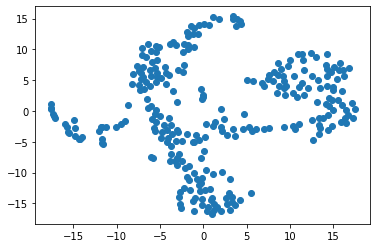

In [29]:
# Defining Model
model = TSNE(learning_rate=100)

# Fitting Model
transformed = model.fit_transform(merged[['hz','cz','az','cz','sz']])

# Plotting 2d t-Sne
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.scatter(x_axis, y_axis)
plt.show()

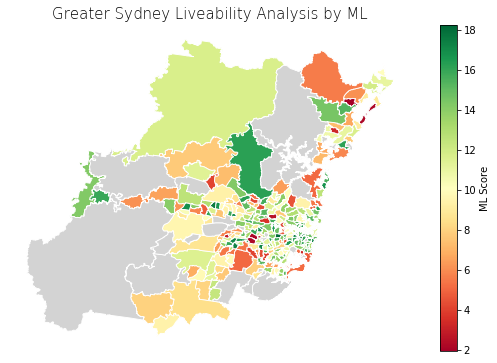

In [30]:
import math
data=[]
ML_merged=merged.copy()
for i in range(len(x_axis)) :
    new_row = math.sqrt(x_axis[i]**2 + y_axis[i]**2)
    data.append([new_row])

ML_df = pd.DataFrame(data,columns=['ML_Score'])
# ML_df
ML_merged = pd.concat([merged.reset_index(), ML_df], axis=1)
ML_merged = pd.concat([ML_merged, gdf4], axis=0)
# ML_merged

fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Greater Sydney Liveability Analysis by ML', fontdict={'fontsize': '15', 'fontweight' : '3'})

ML_merged.plot(column='ML_Score',
            cmap='RdYlGn',
            linewidth=0.9,
            ax=ax,
            edgecolor='1',
            legend=True, 
            legend_kwds={"label": "ML Score"},
            missing_kwds={"color": "lightgrey"})

## Closing Connections

Now, having completed our analysis, we will close our connection to the PostgreSQL server.

In [101]:
conn.close()
db.dispose()

AttributeError: 'NoneType' object has no attribute 'close'

In [32]:
# neighbourhoods_test = pd.read_csv('Neighbourhoods.csv')
# len(neighbourhoods_test)
# merged.drop(merged.index[0])
# neighbourhoods[neighbourhoods.isnull().T.any()]
# len(neighbourhoods)
# neighbourhoods_test = neighbourhoods_test.drop(neighbourhoods_test[neighbourhoods_test.isnull().T.any()].index)
# neighbourhoods.loc[neighbourhoods['area_id'] == 117011324]
# len(gdf4)
# merged2.loc[(merged2['hz']>=3) | (merged2['rz']>=3) | (merged2['az']>=3) | (merged2['cz']>=3) | (merged2['sz']>=3)]
# ML_merged.sort_values('ML_Score', ascending=False)
# merged2
transformed

array([[ -3.0126717 ,   1.4138361 ],
       [-14.922591  ,  -1.4692509 ],
       [  3.4631443 ,  15.364733  ],
       [  3.8920355 ,  15.008865  ],
       [  4.201543  ,  14.648781  ],
       [  3.3921313 ,  14.897474  ],
       [  4.289369  ,  14.17383   ],
       [  3.7267313 ,  13.802332  ],
       [ 15.797209  ,   7.762052  ],
       [  1.7691486 ,  14.925979  ],
       [ 14.137272  ,   7.4799247 ],
       [ 15.069598  ,   7.138757  ],
       [ 14.227368  ,   9.228926  ],
       [ 12.944432  ,   8.744152  ],
       [ 15.654291  ,   6.6532893 ],
       [ 11.485465  ,   8.278411  ],
       [  0.10752857,  14.124947  ],
       [ 14.704326  ,   6.2976074 ],
       [ 14.316941  ,   6.7516975 ],
       [ 10.045492  ,   8.25456   ],
       [  1.1191828 ,  15.227491  ],
       [ 10.914588  ,   9.265715  ],
       [ 16.220562  ,   5.652579  ],
       [ -0.44418275,  14.002003  ],
       [ 11.430504  ,   9.325307  ],
       [  0.6670682 ,  13.982732  ],
       [ 12.57633   ,   5.734623  ],
 